# Hate Speech Detector 2.0
---
**Vectorizers quality analysis with application of Simple Machine Learning classifier** (part 2/2)

1. Load lemmatized tweets.
2. Select severe vectorizers to analysis.
3. Select the best Simple ML Classifier from the previous task (**RandomForest with entropy loss**).
4. Perform multilabel classification task using different vectorizers.
5. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
6. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.vectorizers.TextPretrainedFTVectorizer import TextPretrainedFTVectorizer
from src.vectorizers.TextOwnTrainedFTVectorizer import TextOwnTrainedFTVectorizer
from src.vectorizers.TextPretrainedBERTVectorizer import TextPretrainedBERTVectorizer
from src.vectorizers.TextOwnTrainedBERTVectorizer import TextOwnTrainedBERTVectorizer

from src.classifiers.DLVectorClassifier import DLVectorClassifier
from src.nn.models import DenseNet
from src.dataframes.utils import combine_row_wisely, shuffle_dataframe, class_weights
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class
from src.constants import (LABELS, DUPLICATED_PATH, LEMMAS_PATH,
                           DLCV_CHART_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
WEIGHT_TYPE = 2

In [4]:
plt.style.use('ggplot')

## Data loading

### Classes

In [5]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Lemmatized tweets

In [6]:
df_lemmatized = pd.read_csv(LEMMAS_PATH).drop(['id'], axis=1)
df_lemmatized.head(2)

,lemmatized
0,w czwartek musieć poprawić sąd i trybunał
1,żale nałęcz i riposta macierewicz pan być w ko...


### Combined data

In [7]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,lemmatized,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
7511,sąd obecny polski wymiar sprawiedliwość być ko...,0,0,0,0,0,0,0
10434,cbos zdecydowany większość polak ufać policja ...,0,0,0,0,0,0,0


### Class weights

In [8]:
weights = class_weights(df_classes, w_type=WEIGHT_TYPE)
weights

array([1.96630992, 1.95459439, 1.9713761 , 1.9734659 , 1.9341397 ,
       1.93059338, 1.99620037])

## Models implementation and testing

In [9]:
VEC_CLASSES = [TextPretrainedFTVectorizer, TextOwnTrainedFTVectorizer, TextOwnTrainedFTVectorizer,
               TextPretrainedBERTVectorizer, TextOwnTrainedBERTVectorizer,
               TextPretrainedBERTVectorizer, TextOwnTrainedBERTVectorizer,
              ]
VEC_KWARGS = [{}, {'model_type': 'u', 'short_name': 'unsuper'}, {'model_type': 's', 'short_name': 'super'},
              {'model_type': 'bert', 'short_name': 'BERT'},
              {'model_type': 'bert', 'short_name': 'BERT'},
              {'model_type': 'roberta', 'short_name': 'RoBERTa'},
              {'model_type': 'roberta', 'short_name': 'RoBERTa'},
             ]
VEC_LABELS = ['FT-pret', 'FT-mtr-u', 'FT-mtr-s',
              'BERT-pret', 'BERT-retr',
              'RoBERTa-pret', 'RoBERTa-retr',
             ]

In [10]:
channelsX_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

y_preds = list([])

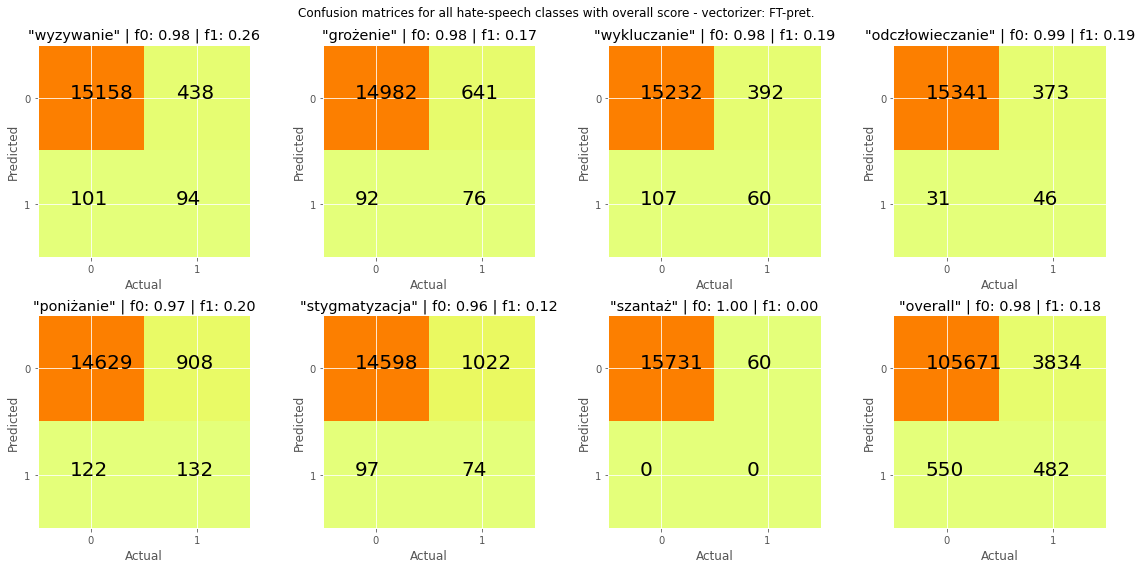

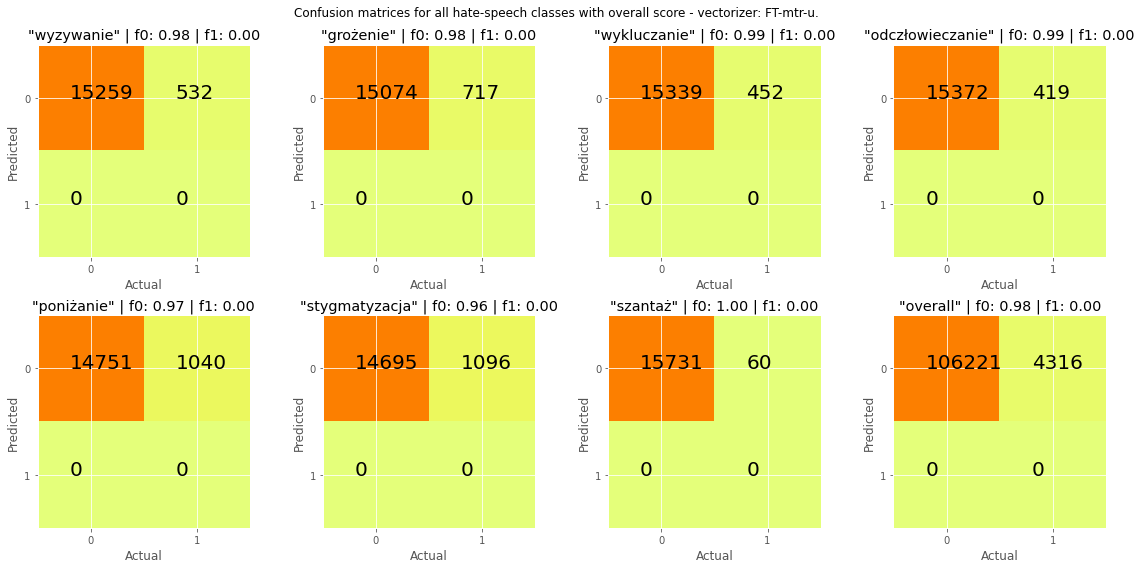

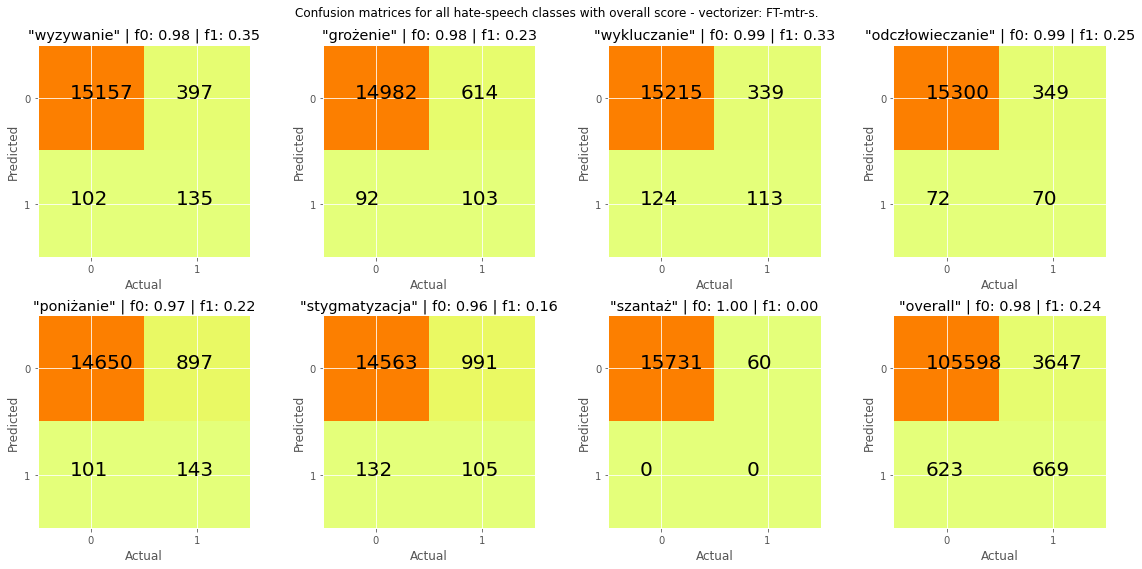

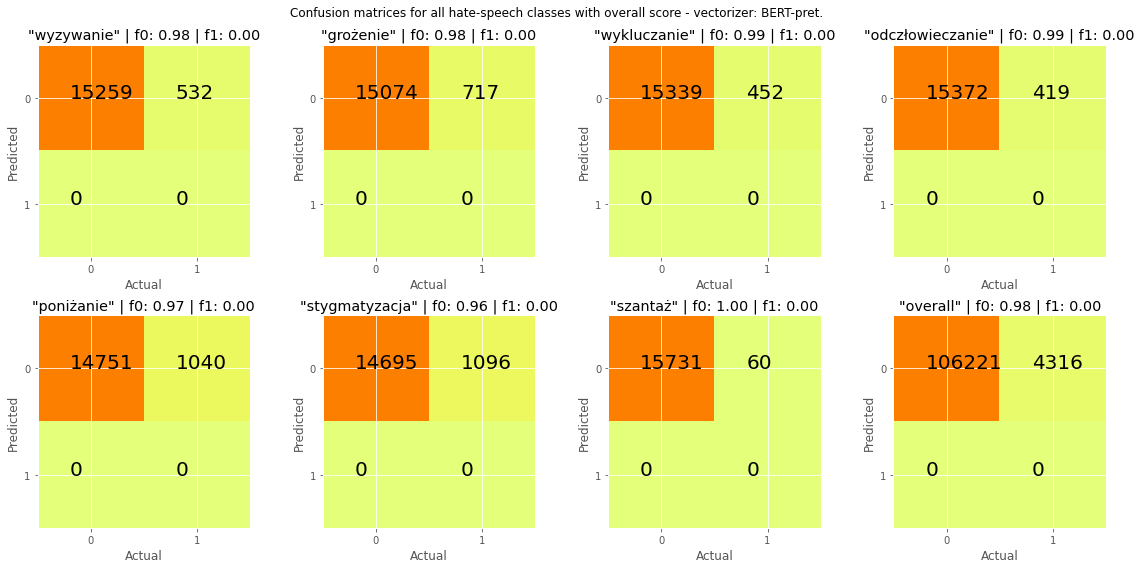

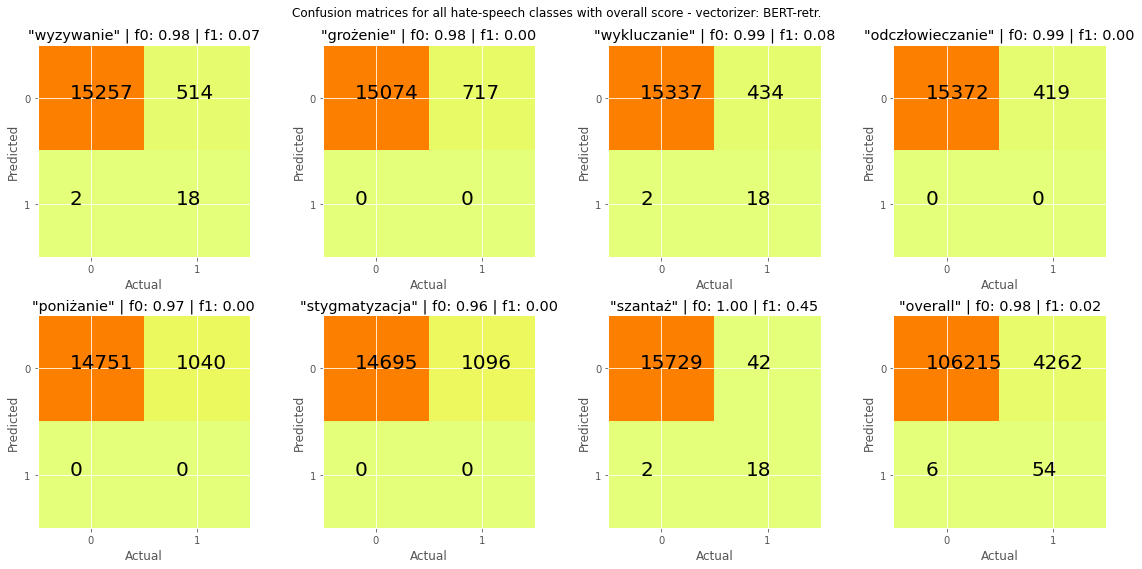

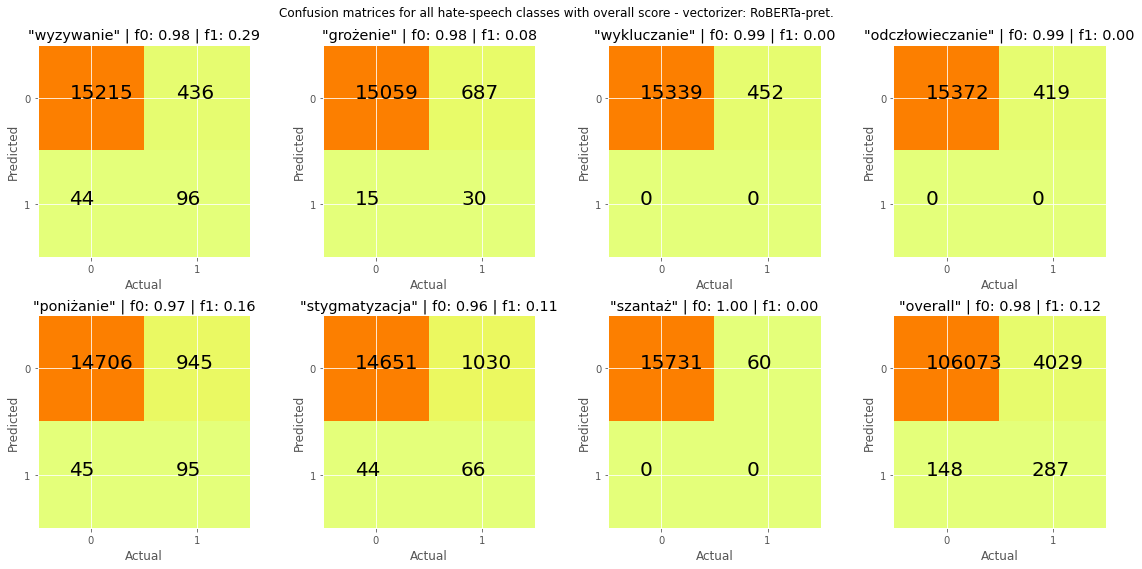

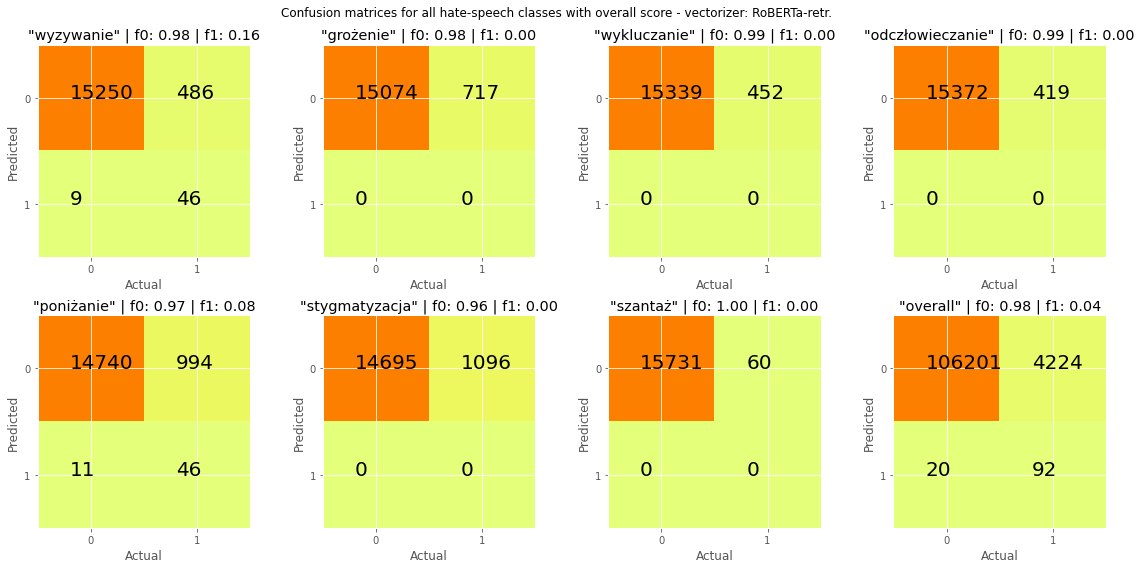

In [11]:
nn_params = {'hidden_size': 500, 'drop_coeff': 0.1, 'n_linear': 3}
for vclass, vkwargs, vlabel in tqdm(zip(VEC_CLASSES, VEC_KWARGS, VEC_LABELS),
                                                   total=len(VEC_LABELS), leave=None):
    clf = DLVectorClassifier(short_name=vlabel, k_folds=5, weights=weights,
                             vec_class=vclass, vec_analysis=True, nn_class=DenseNet,
                             vec_params=vkwargs, nn_params=nn_params)
    
    clf.fit(X_data, y_data)
    # clf.load()
    clf.save()
    
    y_pred = clf.predict(X_data)
    confusion_matrices(y_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score - vectorizer: {vlabel}.',
                       save_file=DLCV_CHART_DIR.replace('{}', f'confusion_matrices_{vlabel}'))
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

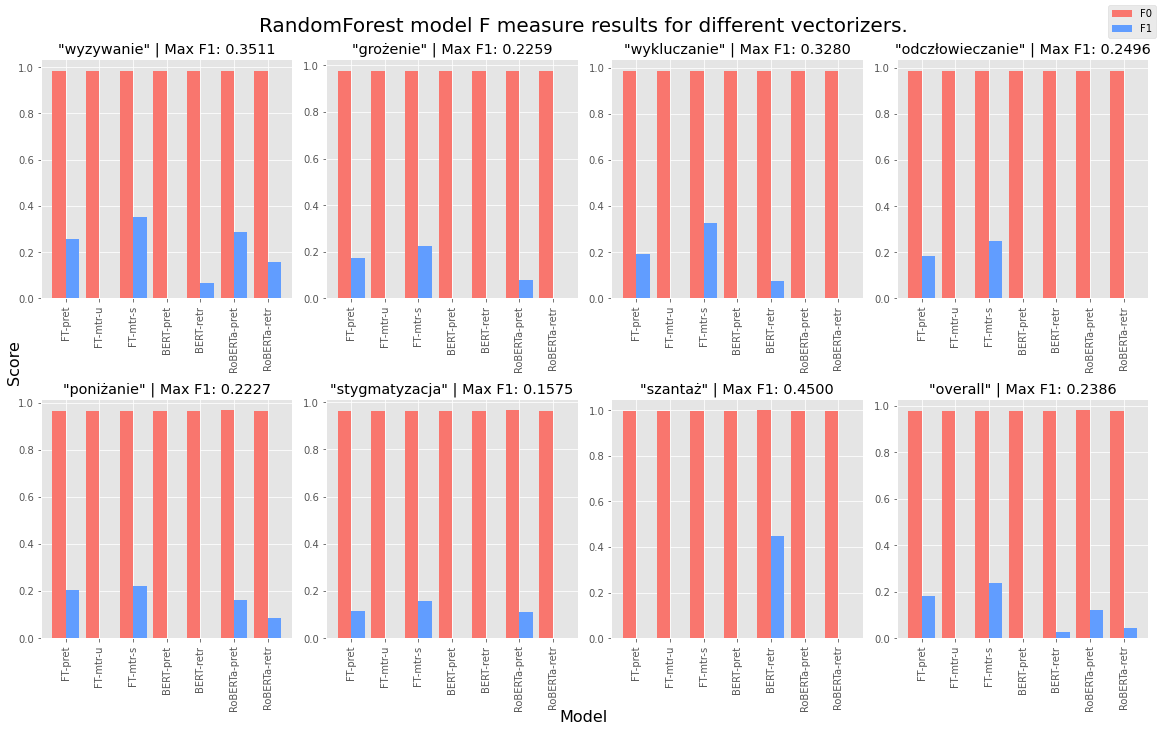

In [12]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='RandomForest model F measure results for different vectorizers.',
                    measure='f', colors=['#f9766e', '#619dff'],
                    save_file=DLCV_CHART_DIR.replace('{}', 'models_F_bars_2'))

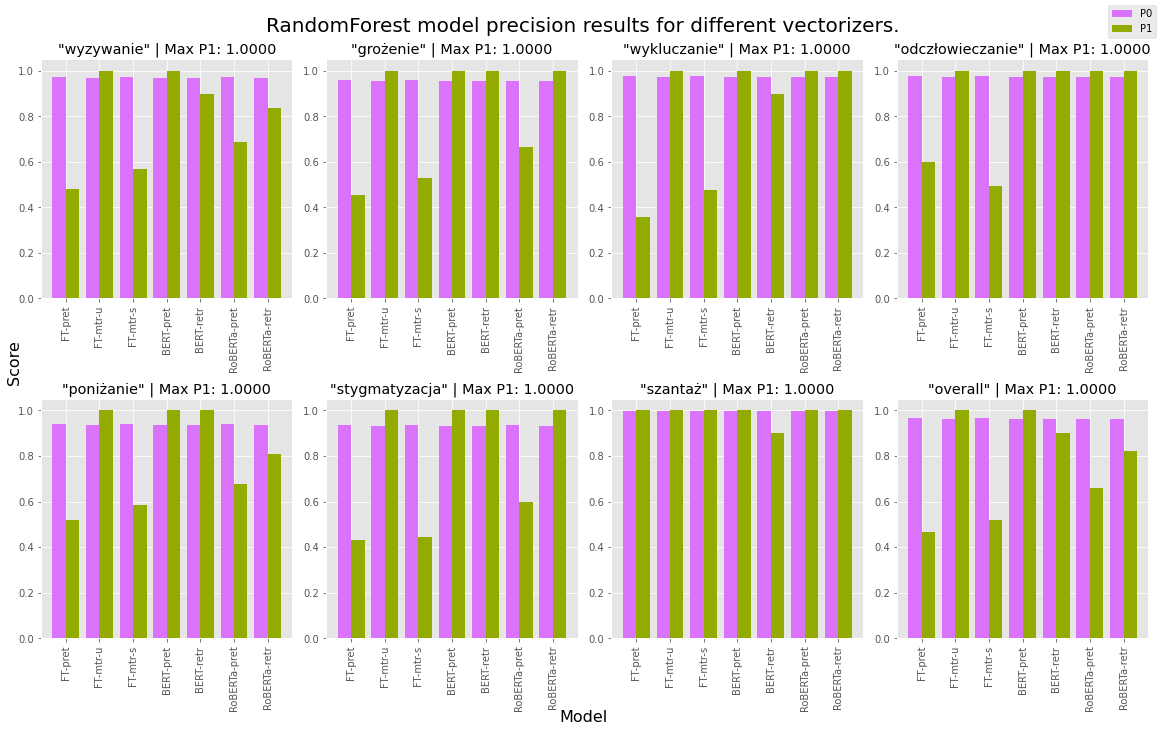

In [13]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='RandomForest model precision results for different vectorizers.',
                    measure='p', colors=['#da72fb', '#93aa00'],
                    save_file=DLCV_CHART_DIR.replace('{}', 'models_P_bars_2'))

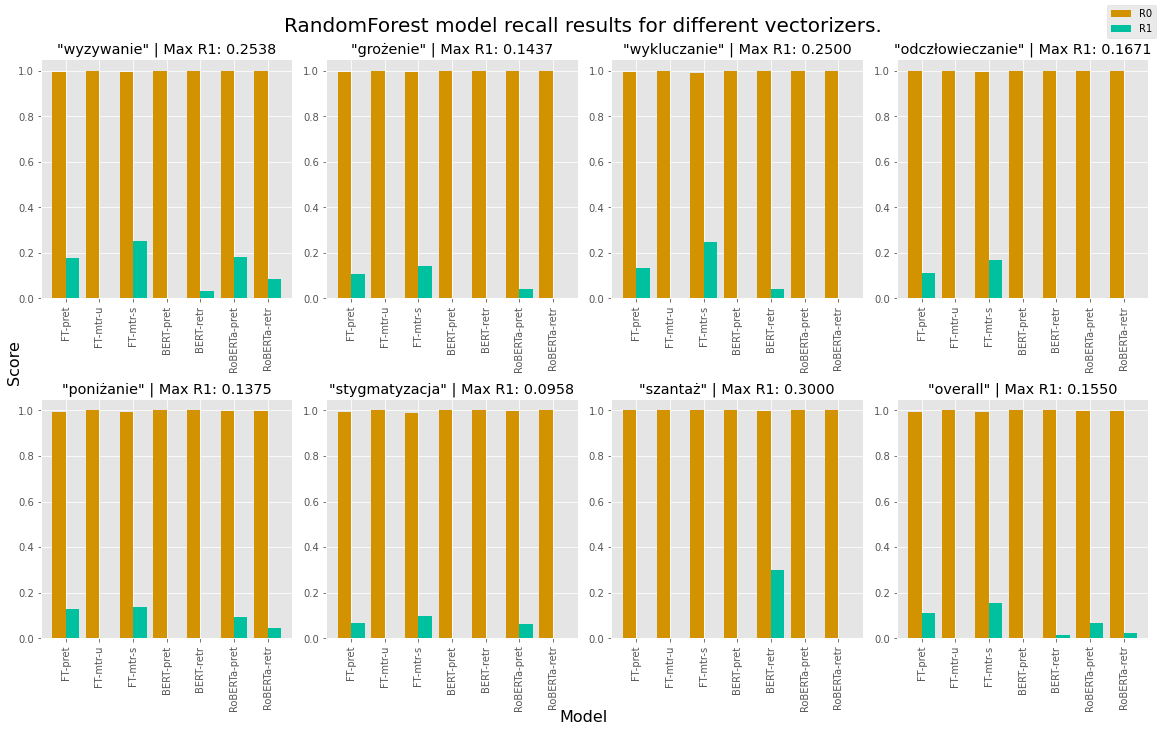

In [14]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='RandomForest model recall results for different vectorizers.',
                    measure='r', colors=['#d39200', '#00c19f'],
                    save_file=DLCV_CHART_DIR.replace('{}', 'models_R_bars_2'))

## Best vectorizer

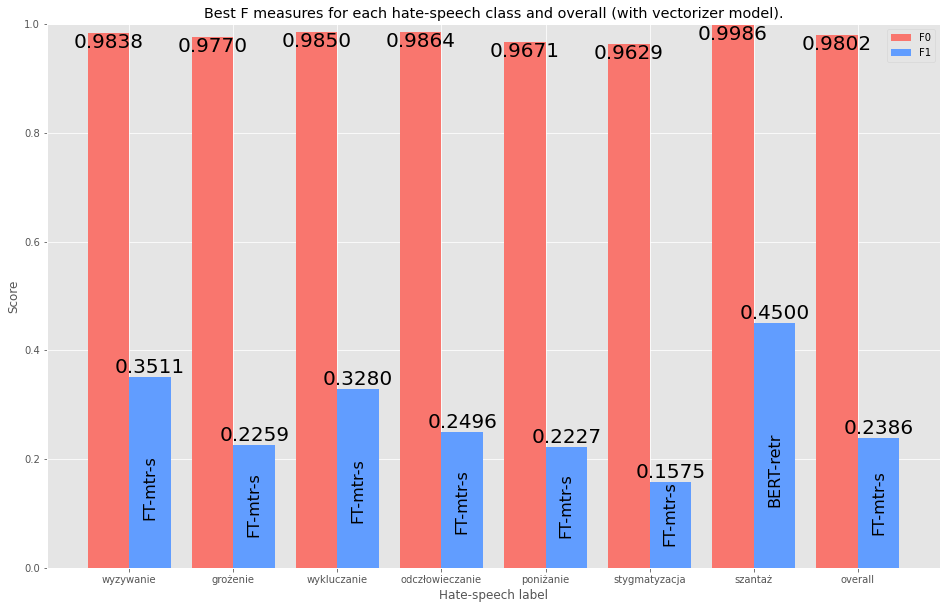

In [15]:
best_model_for_class(y_trues=y_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                     title='Best F measures for each hate-speech class and overall (with vectorizer model).',
                     save_file=DLCV_CHART_DIR.replace('{}', 'best_F_bars_2'))

Judging by the above two analyses the best vectorizer for classifier is **Pretrained Word2Vec CBoW Vectorizer**.

In [16]:
vkwargs = dict({'model_type': 's', 'short_name': 'super'})
clf = DLVectorClassifier(short_name='FT-mtr-s', k_folds=5, weights=weights,
                         vec_class=TextOwnTrainedFTVectorizer,
                         vec_analysis=True, nn_class=DenseNet,
                         vec_params=vkwargs, nn_params=nn_params)
clf.load()

## Training history

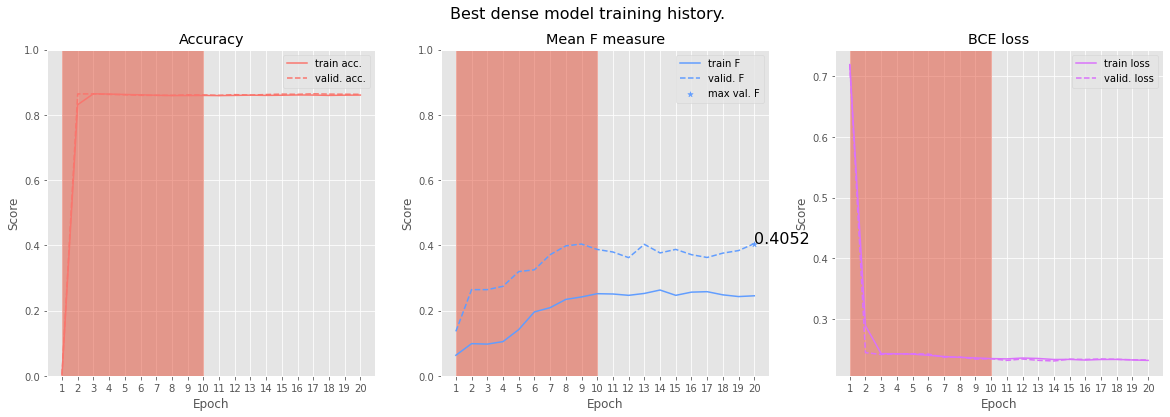

In [17]:
clf.plot_train_history_lines(title='Best dense model training history.',
                             save_file=DLCV_CHART_DIR.replace('{}', f'best_history_lines_2'))

## Tests

### Test 1

In [18]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'stygmatyzacja': 1.0.

### Test 2

In [19]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' as 1.0.

### Test 3

In [20]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'grożenie': 1.0.